# Ungraded Lab: Walkthrough of ML Metadata

Keeping records at each stage of the project is an important aspect of machine learning pipelines. Especially in production models which involve many iterations of datasets and re-training, having these records will help in maintaining or debugging the deployed system. [ML Metadata](https://www.tensorflow.org/tfx/guide/mlmd) addresses this need by having an API suited specifically for keeping track of any progress made in ML projects.

As mentioned in earlier labs, you have already used ML Metadata when you ran your TFX pipelines. Each component automatically records information to a metadata store as you go through each stage. It allowed you to retrieve information such as the name of the training splits or the location of an inferred schema. 

In this notebook, you will look more closely at how ML Metadata can be used directly for recording and retrieving metadata independent from a TFX pipeline (i.e. without using TFX components). You will use TFDV to infer a schema and record all information about this process. These will show how the different components are related to each other so you can better interact with the database when you go back to using TFX in the next labs. Moreover, knowing the inner workings of the library will help you adapt it for other platforms if needed.

Let's get to it!

## Imports

In [1]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

     |████████████████████████████████| 1.6 MB 8.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [2]:
!pip install -q -U tfx

     |████████████████████████████████| 2.4 MB 8.4 MB/s 
     |████████████████████████████████| 19.0 MB 22 kB/s 
     |████████████████████████████████| 454.4 MB 8.8 kB/s 
     |████████████████████████████████| 17.7 MB 78 kB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
     |████████████████████████████████| 6.5 MB 14.4 MB/s 
     |████████████████████████████████| 1.4 MB 47.6 MB/s 
     |████████████████████████████████| 1.7 MB 26.0 MB/s 
     |████████████████████████████████| 40 kB 6.2 MB/s 
     |████████████████████████████████| 189 kB 63.2 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 406 kB 57.2 MB/s 
     |████████████████████████████████| 1.3 MB 63.2 MB/s 
     |████████████████████████████████| 147 kB 63.7 MB/s 
     |████████████████████████████████| 1.2 MB 46.9 MB/s 
     |████████████████████████████████| 135 kB 77.0 MB/s 
     |████████████████████████████████| 1.7 MB 77.7 MB/s 
     |████████████████

In [3]:
!pip install tensorflow_data_validation

In [1]:
#In Colab restart runtime before running this cell 
from ml_metadata.metadata_store import metadata_store
from ml_metadata.proto import metadata_store_pb2

import tensorflow as tf
#print('TF version: {}'.format(tf.__version__))

import tensorflow_data_validation as tfdv
#print('TFDV version: {}'.format(tfdv.version.__version__))

import urllib
import zipfile

## Download dataset

You will be using the [Chicago Taxi](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew) dataset for this lab. Let's download the CSVs into your workspace.

In [2]:
# Download the zip file from GCP and unzip it
url = 'https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/chicago_data.zip'
zip, headers = urllib.request.urlretrieve(url)
zipfile.ZipFile(zip).extractall()
zipfile.ZipFile(zip).close()

print("Here's what we downloaded:")
!ls -R data

Here's what we downloaded:
data:
eval  serving  train

data/eval:
data.csv

data/serving:
data.csv

data/train:
data.csv


## Process Outline

Here is the figure shown in class that describes the different components in an ML Metadata store:

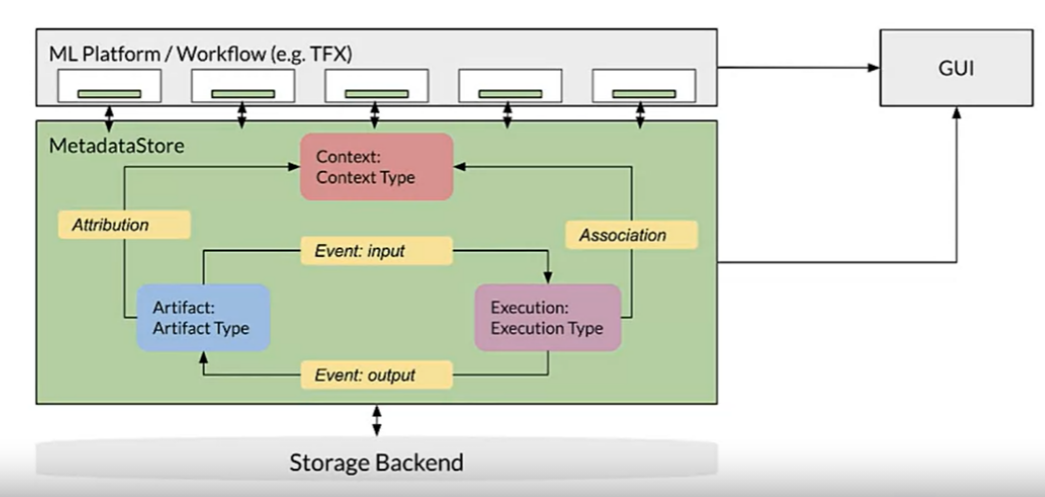

The green box in the middle shows the data model followed by ML Metadata. The [official documentation](https://www.tensorflow.org/tfx/guide/mlmd#data_model) describe each of these and we'll show it here as well for easy reference:

* `ArtifactType` describes an artifact's type and its properties that are stored in the metadata store. You can register these types on-the-fly with the metadata store in code, or you can load them in the store from a serialized format. Once you register a type, its definition is available throughout the lifetime of the store.
* An `Artifact` describes a specific instance of an ArtifactType, and its properties that are written to the metadata store.
* An `ExecutionType` describes a type of component or step in a workflow, and its runtime parameters.
* An `Execution` is a record of a component run or a step in an ML workflow and the runtime parameters. An execution can be thought of as an instance of an ExecutionType. Executions are recorded when you run an ML pipeline or step.
* An `Event` is a record of the relationship between artifacts and executions. When an execution happens, events record every artifact that was used by the execution, and every artifact that was produced. These records allow for lineage tracking throughout a workflow. By looking at all events, MLMD knows what executions happened and what artifacts were created as a result. MLMD can then recurse back from any artifact to all of its upstream inputs.
* A `ContextType` describes a type of conceptual group of artifacts and executions in a workflow, and its structural properties. For example: projects, pipeline runs, experiments, owners etc.
* A `Context` is an instance of a ContextType. It captures the shared information within the group. For example: project name, changelist commit id, experiment annotations etc. It has a user-defined unique name within its ContextType.
* An `Attribution` is a record of the relationship between artifacts and contexts.
* An `Association` is a record of the relationship between executions and contexts.

As mentioned earlier, you will use TFDV to generate a schema and record this process in the ML Metadata store. You will be starting from scratch so you will be defining each component of the data model. The outline of steps involve:

1. Defining the ML Metadata's storage database
1. Setting up the necessary artifact types
1. Setting up the execution types
1. Generating an input artifact unit
1. Generating an execution unit
1. Registering an input event
1. Running the TFDV component
1. Generating an output artifact unit
1. Registering an output event
1. Updating the execution unit
1. Seting up and generating a context unit
1. Generating attributions and associations

You can then retrieve information from the database to investigate aspects of your project. For example, you can find which dataset was used to generate a particular schema. You will also do that in this exercise.

For each of these steps, you may want to have the [MetadataStore API documentation](https://www.tensorflow.org/tfx/ml_metadata/api_docs/python/mlmd/MetadataStore) open so you can lookup any of the methods you will be using to interact with the metadata store. You can also look at the `metadata_store` protocol buffer [here](https://github.com/google/ml-metadata/blob/r0.24.0/ml_metadata/proto/metadata_store.proto) to see descriptions of each data type covered in this tutorial.

## Define ML Metadata's Storage Database

The first step would be to instantiate your storage backend. As mentioned in class, there are several types supported such as fake (temporary) database, SQLite, MySQL, and even cloud-based storage. For this demo, you will just be using a fake database for quick experimentation.

In [3]:
# Instantiate a connection config
connection_config = metadata_store_pb2.ConnectionConfig()

# Set an empty fake database proto
connection_config.fake_database.SetInParent() 

# Setup the metadata store
store = metadata_store.MetadataStore(connection_config)

## Register ArtifactTypes

Next, you will create the artifact types needed and register them to the store. Since our simple exercise will just involve generating a schema using TFDV, you will only create two artifact types: one for the **input dataset** and another for the **output schema**. The main steps will be to:

* Declare an `ArtifactType()`
* Define the name of the artifact type
* Define the necessary properties within these artifact types. For example, it is important to know the data split name so you may want to have a `split` property for the artifact type that holds datasets.
* Use `put_artifact_type()` to register them to the metadata store. This generates an `id` that you can use later to refer to a particular artifact type.

*Bonus: For practice, you can also extend the code below to create an artifact type for the statistics.*

In [4]:
# Create ArtifactType for the input dataset
data_artifact_type = metadata_store_pb2.ArtifactType()
data_artifact_type.name = 'DataSet'
data_artifact_type.properties['name'] = metadata_store_pb2.STRING
data_artifact_type.properties['split'] = metadata_store_pb2.STRING
data_artifact_type.properties['version'] = metadata_store_pb2.INT

# Register artifact type to the Metadata Store
data_artifact_type_id = store.put_artifact_type(data_artifact_type)

# Create ArtifactType for Schema
schema_artifact_type = metadata_store_pb2.ArtifactType()
schema_artifact_type.name = 'Schema'
schema_artifact_type.properties['name'] = metadata_store_pb2.STRING
schema_artifact_type.properties['version'] = metadata_store_pb2.INT

# Register artifact type to the Metadata Store
schema_artifact_type_id = store.put_artifact_type(schema_artifact_type)

# Create ArtifactType for Stats
stats_artifact_type = metadata_store_pb2.ArtifactType()
stats_artifact_type.name = 'Statistics'
stats_artifact_type.properties['name'] = metadata_store_pb2.STRING
stats_artifact_type.properties['version'] = metadata_store_pb2.INT

# Register artifact type to the Metadata Store
stats_artifact_type_id = store.put_artifact_type(stats_artifact_type)

print('Data artifact type:\n', data_artifact_type)
print('Schema artifact type:\n', schema_artifact_type)
print('Statistics artifact type:\n', stats_artifact_type)
print('Data artifact type ID:', data_artifact_type_id)
print('Schema artifact type ID:', schema_artifact_type_id)
print('Statistics artifact type ID:', stats_artifact_type_id)

Data artifact type:
 name: "DataSet"
properties {
  key: "name"
  value: STRING
}
properties {
  key: "split"
  value: STRING
}
properties {
  key: "version"
  value: INT
}

Schema artifact type:
 name: "Schema"
properties {
  key: "name"
  value: STRING
}
properties {
  key: "version"
  value: INT
}

Statistics artifact type:
 name: "Statistics"
properties {
  key: "name"
  value: STRING
}
properties {
  key: "version"
  value: INT
}

Data artifact type ID: 10
Schema artifact type ID: 11
Statistics artifact type ID: 12


## Register ExecutionType

You will then create the execution types needed. For the simple setup, you will just declare one for the data validation component with a `state` property so you can record if the process is running or already completed.

In [5]:
# Create ExecutionType for Data Validation component
dv_execution_type = metadata_store_pb2.ExecutionType()
dv_execution_type.name = 'Data Validation'
dv_execution_type.properties['state'] = metadata_store_pb2.STRING

# Register execution type to the Metadata Store
dv_execution_type_id = store.put_execution_type(dv_execution_type)

print('Data validation execution type:\n', dv_execution_type)
print('Data validation execution type ID:', dv_execution_type_id)

Data validation execution type:
 name: "Data Validation"
properties {
  key: "state"
  value: STRING
}

Data validation execution type ID: 13


## Generate input artifact unit

With the artifact types created, you can now create instances of those types. The cell below creates the artifact for the input dataset. This artifact is recorded in the metadata store through the `put_artifacts()` function. Again, it generates an `id` that can be used for reference.

In [6]:
# Declare input artifact of type DataSet
data_artifact = metadata_store_pb2.Artifact()
data_artifact.uri = '/content/data/train/data.csv'#'./data/train/data.csv'#
data_artifact.type_id = data_artifact_type_id
data_artifact.properties['name'].string_value = 'Chicago Taxi dataset'
data_artifact.properties['split'].string_value = 'train'
data_artifact.properties['version'].int_value = 1

# Submit input artifact to the Metadata Store
data_artifact_id = store.put_artifacts([data_artifact])[0]

print('Data artifact:\n', data_artifact)
print('Data artifact ID:', data_artifact_id)

Data artifact:
 type_id: 10
uri: "/content/data/train/data.csv"
properties {
  key: "name"
  value {
    string_value: "Chicago Taxi dataset"
  }
}
properties {
  key: "split"
  value {
    string_value: "train"
  }
}
properties {
  key: "version"
  value {
    int_value: 1
  }
}

Data artifact ID: 1


## Generate execution unit

Next, you will create an instance of the `Data Validation` execution type you registered earlier. You will set the state to `RUNNING` to signify that you are about to run the TFDV function. This is recorded with the `put_executions()` function.

In [7]:
# Register the Execution of a Data Validation run
dv_execution = metadata_store_pb2.Execution()
dv_execution.type_id = dv_execution_type_id
dv_execution.properties['state'].string_value = 'RUNNING'

# Submit execution unit to the Metadata Store
dv_execution_id = store.put_executions([dv_execution])[0]

print('Data validation execution:\n', dv_execution)
print('Data validation execution ID:', dv_execution_id)

Data validation execution:
 type_id: 13
properties {
  key: "state"
  value {
    string_value: "RUNNING"
  }
}

Data validation execution ID: 1


## Register input event

An event defines a relationship between artifacts and executions. You will generate the input event relationship for dataset artifact and data validation execution units. The list of event types are shown [here](https://github.com/google/ml-metadata/blob/master/ml_metadata/proto/metadata_store.proto#L187) and the event is recorded with the `put_events()` function.

In [8]:
# Declare the input event
input_event = metadata_store_pb2.Event()
input_event.artifact_id = data_artifact_id
input_event.execution_id = dv_execution_id
input_event.type = metadata_store_pb2.Event.DECLARED_INPUT

# Submit input event to the Metadata Store
store.put_events([input_event])

print('Input event:\n', input_event)

Input event:
 artifact_id: 1
execution_id: 1
type: DECLARED_INPUT



## Run the TFDV component

You will now run the TFDV component to generate the schema of dataset. This should look familiar since you've done this already in Week 1.

In [9]:
# Infer a schema by passing statistics to `infer_schema()`
train_data = '/content/data/train/data.csv'#'./data/train/data.csv'
train_stats = tfdv.generate_statistics_from_csv(data_location=train_data)
schema = tfdv.infer_schema(statistics=train_stats)

schema_file = '/content/schema.pbtxt'#'./schema.pbtxt'
tfdv.write_schema_text(schema, schema_file)

print("Dataset's Schema has been generated at:", schema_file)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset's Schema has been generated at: /content/schema.pbtxt


## Generate output artifact unit

Now that the TFDV component has finished running and schema has been generated, you can create the artifact for the generated schema.

In [ ]:
# Declare output artifact of type Schema_artifact
schema_artifact = metadata_store_pb2.Artifact()
schema_artifact.uri = schema_file
schema_artifact.type_id = schema_artifact_type_id
schema_artifact.properties['version'].int_value = 1
schema_artifact.properties['name'].string_value = 'Chicago Taxi Schema'

# Submit output artifact to the Metadata Store
schema_artifact_id = store.put_artifacts([schema_artifact])[0]

print('Schema artifact:\n', schema_artifact)
print('Schema artifact ID:', schema_artifact_id)

Schema artifact:
 type_id: 2
uri: "./schema.pbtxt"
properties {
  key: "name"
  value {
    string_value: "Chicago Taxi Schema"
  }
}
properties {
  key: "version"
  value {
    int_value: 1
  }
}

Schema artifact ID: 2


## Register output event

Analogous to the input event earlier, you also want to define an output event to record the ouput artifact of a particular execution unit.

In [ ]:
# Declare the output event
output_event = metadata_store_pb2.Event()
output_event.artifact_id = schema_artifact_id
output_event.execution_id = dv_execution_id
output_event.type = metadata_store_pb2.Event.DECLARED_OUTPUT

# Submit output event to the Metadata Store
store.put_events([output_event])

print('Output event:\n', output_event)

Output event:
 artifact_id: 2
execution_id: 1
type: DECLARED_OUTPUT



## Update the execution unit

As the TFDV component has finished running successfully, you need to update the `state` of the execution unit and record it again to the store.

In [ ]:
# Mark the `state` as `COMPLETED`
dv_execution.id = dv_execution_id
dv_execution.properties['state'].string_value = 'COMPLETED'

# Update execution unit in the Metadata Store
store.put_executions([dv_execution])

print('Data validation execution:\n', dv_execution)

Data validation execution:
 id: 1
type_id: 3
properties {
  key: "state"
  value {
    string_value: "COMPLETED"
  }
}



## Setting up Context Types and Generating a Context Unit

You can group the artifacts and execution units into a `Context`. First, you need to define a `ContextType` which defines the required context. It follows a similar format as artifact and event types. You can register this with the `put_context_type()` function.

In [ ]:
# Create a ContextType
expt_context_type = metadata_store_pb2.ContextType()
expt_context_type.name = 'Experiment'
expt_context_type.properties['note'] = metadata_store_pb2.STRING

# Register context type to the Metadata Store
expt_context_type_id = store.put_context_type(expt_context_type)

Similarly, you can create an instance of this context type and use the `put_contexts()` method to register to the store.

In [ ]:
# Generate the context
expt_context = metadata_store_pb2.Context()
expt_context.type_id = expt_context_type_id
# Give the experiment a name
expt_context.name = 'Demo'
expt_context.properties['note'].string_value = 'Walkthrough of metadata'

# Submit context to the Metadata Store
expt_context_id = store.put_contexts([expt_context])[0]

print('Experiment Context type:\n', expt_context_type)
print('Experiment Context type ID: ', expt_context_type_id)

print('Experiment Context:\n', expt_context)
print('Experiment Context ID: ', expt_context_id)

Experiment Context type:
 name: "Experiment"
properties {
  key: "note"
  value: STRING
}

Experiment Context type ID:  4
Experiment Context:
 type_id: 4
name: "Demo"
properties {
  key: "note"
  value {
    string_value: "Walkthrough of metadata"
  }
}

Experiment Context ID:  1


## Generate attribution and association relationships

With the `Context` defined, you can now create its relationship with the artifact and executions you previously used. You will create the relationship between schema artifact unit and experiment context unit to form an `Attribution`.
Similarly, you will create the relationship between data validation execution unit and experiment context unit to form an `Association`. These are registered with the `put_attributions_and_associations()` method.

In [ ]:
# Generate the attribution
expt_attribution = metadata_store_pb2.Attribution()
expt_attribution.artifact_id = schema_artifact_id
expt_attribution.context_id = expt_context_id

# Generate the association
expt_association = metadata_store_pb2.Association()
expt_association.execution_id = dv_execution_id
expt_association.context_id = expt_context_id

# Submit attribution and association to the Metadata Store
store.put_attributions_and_associations([expt_attribution], [expt_association])

print('Experiment Attribution:\n', expt_attribution)
print('Experiment Association:\n', expt_association)

Experiment Attribution:
 artifact_id: 2
context_id: 1

Experiment Association:
 execution_id: 1
context_id: 1



## Retrieving Information from the Metadata Store

You've now recorded the needed information to the metadata store. If we did this in a persistent database, you can track which artifacts and events are related to each other even without seeing the code used to generate it. See a sample run below where you investigate what dataset is used to generate the schema. (**It would be obvious which dataset is used in our simple demo because we only have two artifacts registered. Thus, assume that you have thousands of entries in the metadata store.*)

In [ ]:
# Get artifact types
store.get_artifact_types()

[id: 1
 name: "DataSet"
 properties {
   key: "name"
   value: STRING
 }
 properties {
   key: "split"
   value: STRING
 }
 properties {
   key: "version"
   value: INT
 },
 id: 2
 name: "Schema"
 properties {
   key: "name"
   value: STRING
 }
 properties {
   key: "version"
   value: INT
 }]

In [ ]:
# Get 1st element in the list of `Schema` artifacts.
# You will investigate which dataset was used to generate it.
schema_to_inv = store.get_artifacts_by_type('Schema')[0]

# print output
print(schema_to_inv)

id: 2
type_id: 2
uri: "./schema.pbtxt"
properties {
  key: "name"
  value {
    string_value: "Chicago Taxi Schema"
  }
}
properties {
  key: "version"
  value {
    int_value: 1
  }
}
create_time_since_epoch: 1621639851631
last_update_time_since_epoch: 1621639851631



In [ ]:
# Get events related to the schema id
schema_events = store.get_events_by_artifact_ids([schema_to_inv.id])

print(schema_events)

[artifact_id: 2
execution_id: 1
type: DECLARED_OUTPUT
milliseconds_since_epoch: 1621639867452
]


You see that it is an output of an execution so you can look up the execution id to see related artifacts.

In [ ]:
# Get events related to the output above
execution_events = store.get_events_by_execution_ids([schema_events[0].execution_id])

print(execution_events)

[artifact_id: 1
execution_id: 1
type: DECLARED_INPUT
milliseconds_since_epoch: 1621639807384
, artifact_id: 2
execution_id: 1
type: DECLARED_OUTPUT
milliseconds_since_epoch: 1621639867452
]


You see the declared input of this execution so you can select that from the list and lookup the details of the artifact.

In [ ]:
# Look up the artifact that is a declared input
artifact_input = execution_events[0]

store.get_artifacts_by_id([artifact_input.artifact_id])

[id: 1
 type_id: 1
 uri: "./data/train/data.csv"
 properties {
   key: "name"
   value {
     string_value: "Chicago Taxi dataset"
   }
 }
 properties {
   key: "split"
   value {
     string_value: "train"
   }
 }
 properties {
   key: "version"
   value {
     int_value: 1
   }
 }
 create_time_since_epoch: 1621639740363
 last_update_time_since_epoch: 1621639740363]

Great! Now you've fetched the dataset artifact that was used to generate the schema. You can approach this differently and we urge you to practice using the different methods of the [MetadataStore API](https://www.tensorflow.org/tfx/ml_metadata/api_docs/python/mlmd/MetadataStore) to get more familiar with interacting with the database.

### Wrap Up

In this notebook, you got to practice using ML Metadata outside of TFX. This should help you understand its inner workings so you will know better how to query ML Metadata stores or even set it up for your own use cases. TFX leverages this library to keep records of pipeline runs and you will get to see more of that in the next labs. Next up, you will review how to work with schemas and in the next notebook, you will see how it can be implemented in a TFX pipeline.